# NN with 3 hidden nodes

1) define necessary functions

2) load data

3) train NN

4) sample posterior

5) plot posterior with evolution of NN during training

In [1]:
import numpy as np
#import math as math
import matplotlib.pyplot as plt

### Functions

##### force and classifier of NN with 3 hidden nodes

In [2]:
def sig_act(s):
    return 1.0/(1.0+np.exp(-s))

def sig_act_prime(s):
    return np.exp(-s)/(1.0+np.exp(-s))**2

def p_force_h3(theta):
    '''Force for network with 3 hidden nodes
    IMPORTANT: length of theta MUST be 13!!!
    '''
    
# Calculate negative gradient of L2 loss function (and the loss) for 
# a two input function modelled with a two layer (2 hidden node) network
# using sigmoidal activation
# input - parameter vector *theta*
# output - negative gradient of L2 loss *F* and *loss*

    #change to weight, bias notation
    w11 = theta[0]; w12 = theta[1]; w21 = theta[2]; w22 =theta[3]; w31 = theta[4]; w32 =theta[5];
    wo1 = theta[6]; wo2 = theta[7]; wo3 = theta[8]
    b1 = theta[9]; b2=theta[10]; b3=theta[11]; 
    bo=theta[12]
    
    g = np.zeros((13,1));           # g = gradient - start with a zero vector 
    loss = 0                       # training loss

    for i in range(len(circle_data)):
        x1 = circle_data[i][0]; x2 = circle_data[i][1]; c = circle_data[i][2];
   
        # calculate intermediates and output of network
        u1 = w11*x1 + w12*x2 + b1
        u2 = w21*x1 + w22*x2 + b2
        u3 = w31*x1 + w32*x2 + b3
      
        z1 = sig_act(u1)            # hidden node outputs
        z2 = sig_act(u2)
        z3 = sig_act(u3)
        uo = wo1*z1 + wo2*z2 + wo3*z3 +bo    # 2nd layer
        
        out = sig_act(uo)
        res = c-out
        loss = loss + res**2        # update the L2 loss
        
        # now calculate the loss gradient components in reverse order
        ho = -2*res*sig_act_prime(uo) 
        
        g[12] += ho                  # deriv with respect to bias bo
        g[8] += ho*z3               # wrt wo3
        g[7] += ho*z2               # wrt wo2
        g[6] += ho*z1               # wrt wo1
        
        h3 = ho* sig_act_prime(u3)  # multipliers
        h2 = ho* sig_act_prime(u2)  # multipliers
        h1 = ho* sig_act_prime(u1)
        
        g[11] += h3*wo3              # wrt b3
        g[10] += h2*wo2              # wrt b2
        g[9] += h1*wo1              # wrt b1
        
        g[5] += h3*wo3*x2           # wrt w32
        g[4] += h3*wo3*x1           # wrt w31
        g[3] += h2*wo2*x2           # wrt w22
        g[2] += h2*wo2*x1           # wrt w21
        g[1] += h1*wo1*x2           # wrt w12
        g[0] += h1*wo1*x1           # wrt w11

# negate the gradient to get the descent direction

    F = -g

    return F,loss

def p_classifier_h3(x1,x2,theta):
# compute 2-layer planar perceptron classifier for given inputs x1, x2
# parameter theta: a nine component vector

    #change to weight, bias notation
    w11 = theta[0]; w12 = theta[1]; w21 = theta[2]; w22 =theta[3]; w31 = theta[4]; w32 =theta[5];
    wo1 = theta[6]; wo2 = theta[7]; wo3 = theta[8] #weights output layer
    b1 = theta[9]; b2=theta[10]; b3=theta[11]; #biasis hidden layer
    bo=theta[12] #bias output layer

# calculate intermediates and output of network
    u1 = w11*x1 + w12*x2 + b1
    u2 = w21*x1 + w22*x2 + b2
    u3 = w31*x1 + w32*x2 + b3
    
    z1 = sig_act(u1)            # hidden node outputs
    z2 = sig_act(u2)
    z3 = sig_act(u3)
    uo = wo1*z1 + wo2*z2 + wo3*z3 +bo    # 2nd layer
        
    out = sig_act(uo)

    return(out)

##### general functions to train NN

In [3]:
def Euler(q_n, h, vector_field):
# computes a step using Euler's method for the given vector field
    F,loss = vector_field(q_n)
    return q_n + h*F, loss

def compute_trajectory( q0, Nsteps, h,  step_function, vector_field):
# computes a trajectory of length *Nsteps*
# for a differential equation defined by *vector_field*
# starting from a given initial condition *q0*
# using a given method defined by *step_function*
# with stepsize *h*
#
# outputs independent variable values *t_traj*, 
# trajectory *q_traj* whose jth column is the solution at time level j

    # initialize trajectory
    q_traj = [q0]; t_traj = [0]
    F,loss = vector_field(q0)
    loss_traj = [loss]

    # starting values
    q = q0; t = 0
    
    # loop
    for n in range(Nsteps):
        # calculate next step using provided stepping function
        q,loss  = step_function(q, h,  vector_field)
        t +=  h

        # update trajectory
        q_traj.append(q)
        t_traj.append(t)
        loss_traj.append(loss)

    return q_traj, t_traj, loss_traj

##### Functions for MCMC sampling

In [4]:
##### Loss of NN ############
def Loss(data, theta):
    '''returns Loss for provided separation line'''
    
    #calculate class prediction with specified line c_hat = sig(y - kx -d)
    loss = 0
    for i in range(len(data)):
        c_hat = p_classifier_h3(data[i,0], data[i,1] ,theta)
        loss += (data[i,2] - c_hat)**2

    return loss

##### Priors ################
def prior(theta):
    '''Uniform prior on 13-dimensional cube [-10, 10]^d'''
    return int(all(np.abs(theta) < 10))

import scipy.stats as stats
def ll_norm_prior(theta):
    return np.sum(stats.norm.logpdf(theta, scale=3))

##### Random Walk Metropolis hastings  ##############
def random_walk_metropolis_hastings(data, ntot, proposal_sd, theta_init):
    theta_save = np.zeros((ntot, 13))
    Loss_save = np.zeros(ntot)
    accept = 0

    theta_current = theta_init
    theta_prop = theta_current.copy()

    Loss_current = Loss(data, theta_current.tolist())
    
    for i in range(ntot):
        #store current state of MCMC chain
        theta_save[i,:] = theta_current
        Loss_save[i] = Loss_current
        
        #draw a proposal
        theta_prop = np.random.normal(theta_current, proposal_sd, size = 13)

        #Loss_current = Loss(circle_data, theta_current.tolist())
        #evaluate Loss of theta proposal state
        Loss_prop = Loss(data, theta_prop.tolist())
            
        #evaluate acceptance probability of proposal state
        #NOTICE: posterior = exp(-Loss(theta))
        #use logarithm for numerical stability 
        #alpha = np.log(prior(theta_prop) * np.exp(-Loss_prop)) - np.log(prior(theta_current) * np.exp(-Loss_current))
        alpha = ll_norm_prior(theta_prop) + np.log(np.exp(-Loss_prop)) - (ll_norm_prior(theta_current) + np.log(np.exp(-Loss_current)))
                                                   
        #update state with probability alpha
        u = np.random.uniform(size = 1)
        if alpha > np.log(u):
            theta_current = theta_prop.copy()
            Loss_current = Loss_prop
            accept += 1
        #else:
        #    theta_prop = theta_current.copy() #proposal was declined -> reset to current state
        
    return [theta_save, accept, Loss_save]

### Load data

In [5]:
circle_data = np.loadtxt('circle_data.csv', delimiter=',')

In [6]:
tdata = np.loadtxt('tdata.csv', delimiter=',')

# Circle data

### Train NN

Text(0, 0.5, 'training loss')

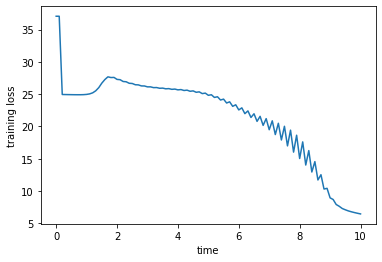

In [7]:
theta,t,loss = compute_trajectory(np.random.random((13,1)),100,.1,Euler,p_force_h3)
plt.plot(t,loss); plt.xlabel('time'); plt.ylabel('training loss')

### Sample posterior

Several MCMC chains with sparse initializations

In [8]:
ntot = 100000 #number of draws for each chain

#chain_inits = [np.random.normal(size = (9)), 
#               np.random.normal(loc = 3, size = (9)), 
#               np.random.normal(loc = -3, size = (9))]
chain_inits = [np.random.uniform(low = -10, high = 10, size = (13)), 
               np.random.uniform(low = -10, high = 10, size = (13)), 
               np.random.uniform(low = -10, high = 10, size = (13))]
chains_theta_save = []
chains_accept = []
chains_Loss_save = []

for c in chain_inits:
    theta_save, accept, Loss_save = random_walk_metropolis_hastings(data=circle_data, ntot=ntot, proposal_sd=0.7, theta_init=c)
    chains_theta_save.append(theta_save)
    chains_accept.append(accept)
    chains_Loss_save.append(Loss_save)

In [9]:
## Save sampled chains
np.savetxt('nn_h3_chain1.csv', chains_theta_save[0], delimiter = ',')
np.savetxt('nn_h3_chain2.csv', chains_theta_save[1], delimiter = ',')
np.savetxt('nn_h3_chain3.csv', chains_theta_save[2], delimiter = ',')

np.savetxt('nn_h3_accept.csv', chains_accept, delimiter = ',')

np.savetxt('nn_h3_Loss1.csv', chains_Loss_save[0], delimiter = ',')
np.savetxt('nn_h3_Loss2.csv', chains_Loss_save[1], delimiter = ',')
np.savetxt('nn_h3_Loss3.csv', chains_Loss_save[2], delimiter = ',')

In [10]:
#Some statistics of chains

nburn = int(ntot*0.5) #burn 50% of chains
#n = ntot - nburn

for c, Loss_save in enumerate(chains_Loss_save):
    print(f'Chain {c}')
    print(f'acceptance rates: {chains_accept[c]/ntot}')
    print(f'min Loss: {Loss_save[nburn:].min()}')
    print(f'mean Loss: {Loss_save[nburn:].mean()}')
    print(f'max Loss: {Loss_save[nburn:].max()}')
    print(f'std Loss: {Loss_save[nburn:].std()}')

Chain 0
acceptance rates: 0.18578
min Loss: 0.9444489013957963
mean Loss: 8.02091134389612
max Loss: 26.30357569081733
std Loss: 3.2257745372591455
Chain 1
acceptance rates: 0.1923
min Loss: 1.1892855894667171
mean Loss: 7.897616773879149
max Loss: 23.4673068601432
std Loss: 2.836105996831097
Chain 2
acceptance rates: 0.18828
min Loss: 0.5609421237114001
mean Loss: 8.348117069329252
max Loss: 21.55460918134789
std Loss: 2.7566472776464064


### Plot marginal posteriors

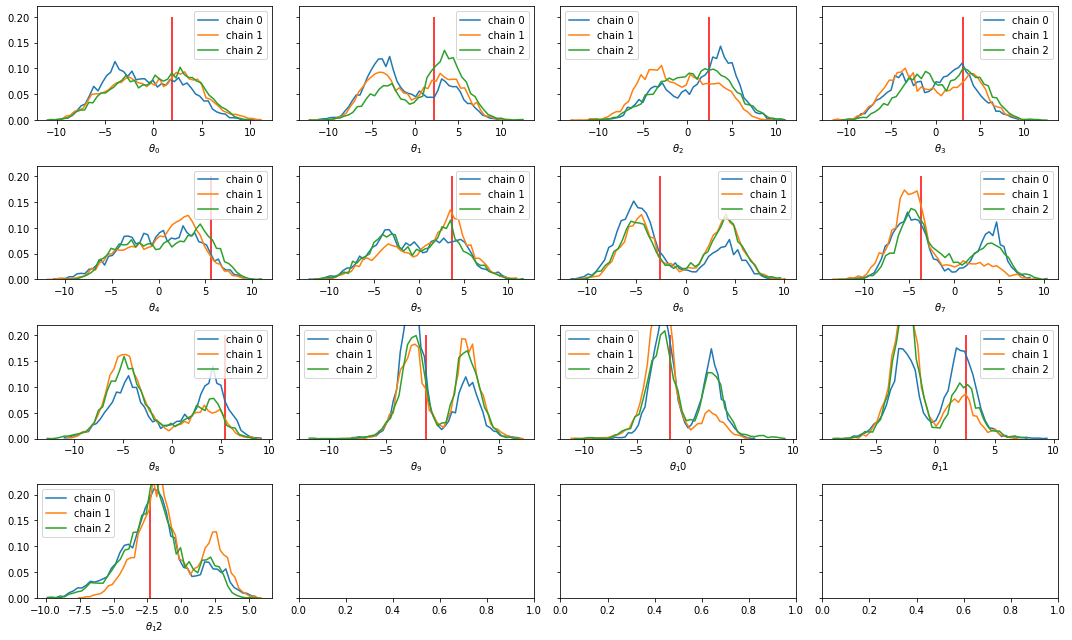

In [11]:
theta_sgd = theta[-1] #trained standard NN

fig, axs = plt.subplots(4,4, sharey='row', figsize=(15,9))

for i, ax in enumerate(axs.flatten()):
    if i > 12:
        continue
    for c, theta_save in enumerate(chains_theta_save):
        aa1,bb1 = np.histogram(theta_save[nburn:,i], bins=50,density=True)
        ax.plot(bb1[:-1],aa1, label=f'chain {c}')
    
    ax.set_xlabel(r'$\theta$'+f'$_{i}$')
    ax.legend()
    #ax.set_ylabel('density')
    
    #Add NN from SGD optimiation
    ax.vlines(x=theta_sgd[i], ymin=0, ymax=0.2, colors='red')
    
    ax.set_ylim((0,0.22))


plt.tight_layout()
plt.show()

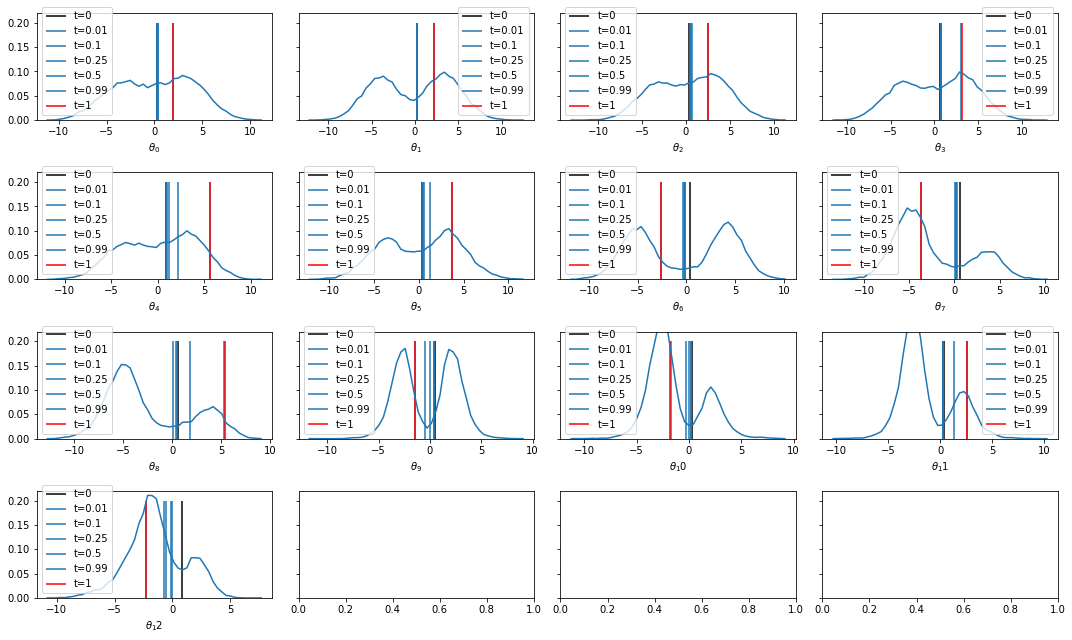

In [12]:
n_train_steps = len(theta)

#draws from all chains
theta_save = np.concatenate((chains_theta_save[0], chains_theta_save[1], chains_theta_save[2]))

fig, axs = plt.subplots(4,4, sharey='row', figsize=(15,9))

for i, ax in enumerate(axs.flatten()):
    if i > 12:
        continue
        
    aa1,bb1 = np.histogram(theta_save[nburn:,i], bins=50,density=True)
    ax.plot(bb1[:-1],aa1)
    
    
    ax.set_xlabel(r'$\theta$'+f'$_{i}$')
    #ax.set_ylabel('density')
    
    #Add evolution of weights during standard training
    ax.vlines(x=theta[0][i], ymin=0, ymax=0.2, colors = 'black', label = 't=0')

    time_shares = [0.01, 0.1, 0.25, 0.5, 0.99]
    for t in time_shares:
        #ax.vlines(x=theta[(n_train_steps*t)//10 -1][i], ymin=0, ymax=0.2, label = f't={t/10}')
        ax.vlines(x=theta[int(t*n_train_steps)][i], ymin=0, ymax=0.2, label = f't={t}')
    ax.vlines(x=theta[-1][i], ymin=0, ymax=0.2, colors = 'red', label = 't=1')
    
    ax.legend()
    ax.set_ylim((0,0.22))


plt.tight_layout()
plt.show()

- Compute loss for theta gathered from mode of distributions above and comapre to gradient descent ( red markers ) loss.
- plot classification graph for new parameter